# Fake News Binary Classification by Logistic Regression and BERT

## Setup and Configuration

### Install the required libraries:

In [ ]:
!pip install tensorflow_text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=8e11498a4f9c7c586e83afefe9cf5368cde0fb1681cd39e48e4428b4dbd7b62c
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Su

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1" # Forces TensorFlow to use the older version of Keras

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
import tensorflow_text as text

In [ ]:
import json
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from google.colab import drive
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

nltk.download("stopwords")
nltk.download('wordnet')

drive.mount("/content/drive")
project_path = "/content/drive/MyDrive/Colab Notebooks/NLP Project"


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


In [ ]:
# Utiliti function to get the project path in Google Drive
def get_drive_path(file_name):
  return os.path.join(project_path, file_name)

### Load and Explore the Data

In [ ]:
df = pd.read_csv(get_drive_path("WELFake_Dataset.csv")) # Create data frame from dataset
df.head(10) # Display the first 10 rows of the dataset

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
7,7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,1
8,8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [ ]:
# Check the target column to identify any potential data imbalance in the data
df['label'].value_counts()

,count
label,
1,37106
0,35028


In [ ]:
# Check the dimensions of the dataset
df.shape

(72134, 4)

In [ ]:
# Check if there are missing values in the dataset
df.isna().sum()

,0
Unnamed: 0,0
title,558
text,39
label,0


In [ ]:
# Drop the enties with missing values
df = df.dropna()

In [ ]:
# Recheck for missing values
df.isna().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


In [ ]:
# Reset the index
df.reset_index(inplace=True, drop=True)
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [ ]:
# Drop the unnecessary column from the dataset
df = df.drop(columns=["Unnamed: 0"], axis=1)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [ ]:
df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
71532,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
71533,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
71534,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
71535,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [ ]:
# Example data for debugging purposes
# data = df_text.sample(n=100, random_state=42)

In [ ]:
# Authorized dataset used for training
data = df[["text", "label"]]
data

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,"Now, most of the demonstrators gathered last ...",1
2,A dozen politically active pastors came here f...,0
3,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
4,All we can say on this one is it s about time ...,1
...,...,...
71532,WASHINGTON (Reuters) - Hackers believed to be ...,0
71533,"You know, because in fantasyland Republicans n...",1
71534,Migrants Refuse To Leave Train At Refugee Camp...,0
71535,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [ ]:
# Check the content of the text column
data['text']

,text
0,No comment is expected from Barack Obama Membe...
1,"Now, most of the demonstrators gathered last ..."
2,A dozen politically active pastors came here f...
3,"The RS-28 Sarmat missile, dubbed Satan 2, will..."
4,All we can say on this one is it s about time ...
...,...
71532,WASHINGTON (Reuters) - Hackers believed to be ...
71533,"You know, because in fantasyland Republicans n..."
71534,Migrants Refuse To Leave Train At Refugee Camp...
71535,MEXICO CITY (Reuters) - Donald Trump’s combati...


In [ ]:
# Check the content of the label column
data['label']

,label
0,1
1,1
2,0
3,1
4,1
...,...
71532,0
71533,1
71534,0
71535,0


## Logistic Regression Implementation

### Data Preprocessing

In [ ]:
lm = WordNetLemmatizer()

def lemmatize_text(column):
    corpus = []
    for i in range(len(df)):
        # Remove non-alphanumeric characters
        review = re.sub("^a-zA-Z0-9", " ", df[column][i])
        # Lowercasing
        review = review.lower()
        # Tokenization
        review = review.split()
        # Lemmatization
        review = [lm.lemmatize(x) for x in review if x not in (stopwords.words('english'))]
        review = " ".join(review)
        corpus.append(review)
    return corpus


# corpus = lemmatize_text("text")

#### Save the preprocessed corpus

In [ ]:
def save_corpus_as(name):
    with open(name, "w", encoding="utf-8") as file:
        json.dump(corpus, file)


# save_corpus_as(get_drive_path("corpus_text.json"))

#### Load the proprocessed corpus

In [ ]:
def load_corpus_from(name):
    # Load proprocessed corpus to json file
    with open(name, "r", encoding="utf-8") as file:
        corpus = json.load(file)
    return corpus


corpus = load_corpus_from(os.path.join(project_path, "corpus_text.json"))

In [ ]:
# Check preprocessed corpus
print(df["text"][0][:100])
print(corpus[0][:100])

No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter 
comment expected barack obama member #fyf911 #fukyoflag #blacklivesmatter movement called lynching h


### Vectorization

In [ ]:
tf_vac = TfidfVectorizer()
# x = tf.fit_transform(corpus).toarray()
# Use scipy.sparse matrices instead of converting the TF-IDF results into dense arrays for memory-efficient
x = tf_vac.fit_transform(corpus)
x

<71537x240680 sparse matrix of type '<class 'numpy.float64'>'
	with 15264912 stored elements in Compressed Sparse Row format>

In [ ]:
y = data['label']
y.head()

,label
0,1
1,1
2,0
3,1
4,1


### Split the dataset into training and testing subsets

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=10, stratify=y
)

### Define the Model

In [ ]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)

### Train the Model

In [ ]:
lr.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## BERT Implementation

### Prepare dataset for BERT

In [ ]:
# Parameters
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE
seed = 42

# Split the dataset into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    data["text"], data["label"], test_size=0.3, random_state=seed
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=seed
)

# Convert the data into TensorFlow datasets
def prepare_dataset(texts, labels):
    return (
        tf.data.Dataset.from_tensor_slices((texts, labels))
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )

train_ds = prepare_dataset(train_texts, train_labels)
val_ds = prepare_dataset(val_texts, val_labels)
test_ds = prepare_dataset(test_texts, test_labels)

# Check the output
for text_batch, label_batch in train_ds.take(1):
    print("Titles:", text_batch.numpy())
    print("Labels:", label_batch.numpy())

Titles: [b'Just a few days after being sworn in as president, Donald J. Trump convened a meeting at the White House of some of the nation\xe2\x80\x99s most prominent chief executives to discuss how to improve manufacturing. Mr. Trump was joined by Elon Musk of Tesla, Mark Fields of Ford, Andrew Liveris of Dow Chemical, Marillyn A. Hewson of Lockheed Martin and Michael Dell of Dell, among others. Before the meeting formally began, with cameras rolling, Mr. Trump wanted to talk about corporate tax rates  \xe2\x80\x94   specifically lowering them. During one debate with Hillary Clinton, he had told voters: \xe2\x80\x9cUnder my plan, I\xe2\x80\x99ll be reducing taxes tremendously, from 35 percent to 15 percent for companies, small and big businesses. That\xe2\x80\x99s going to be a job creator like we haven\xe2\x80\x99t seen since Ronald Reagan. It\xe2\x80\x99s going to be a beautiful thing to watch. \xe2\x80\x9d He repeated the 15 percent figure over and over again. However, when Mr. Trum

In [ ]:
# Check the content of the text column
data['text']

,text
0,No comment is expected from Barack Obama Membe...
1,"Now, most of the demonstrators gathered last ..."
2,A dozen politically active pastors came here f...
3,"The RS-28 Sarmat missile, dubbed Satan 2, will..."
4,All we can say on this one is it s about time ...
...,...
71532,WASHINGTON (Reuters) - Hackers believed to be ...
71533,"You know, because in fantasyland Republicans n..."
71534,Migrants Refuse To Leave Train At Refugee Camp...
71535,MEXICO CITY (Reuters) - Donald Trump’s combati...


### Loading models from TensorFlow Hub



#### The preprocessing model

In [ ]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
text_test = ['A recent U. S. Department of Homeland Security (DHS) report reveals the information technology (IT) used by the government is ineffective to keep tabs on those who overstay visas.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  1037  3522  1057  1012  1055  1012  2533  1997 10759  3036  1006]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Using the BERT model

In [ ]:
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: "small_bert/bert_en_uncased_L-4_H-512_A-8"')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: "small_bert/bert_en_uncased_L-4_H-512_A-8"
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9964443  -0.8938863   0.2816682   0.07686581 -0.54081917  0.9573659
  0.9964911  -0.9064962  -0.20152672  0.30626404  0.05575707 -0.9862151 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.137929    0.25049436  0.9541496  ... -0.83309853 -0.49942818
   0.6412629 ]
 [-1.100447    0.13708156  0.01790078 ... -0.94748765 -1.0051512
   0.938157  ]
 [-1.1147124   0.7231693   0.58091354 ... -0.05366112 -0.30631846
   0.12071386]
 ...
 [-0.42386645 -0.661347   -1.1886165  ... -1.464561   -0.08166869
   1.2934281 ]
 [-0.3187647  -0.19210751  0.19941443 ... -0.8356177   0.48463762
   0.43406725]
 [-0.09253162  0.4834206  -0.11817671 ... -1.063747   -0.29715562
   0.6365413 ]]


### Define the model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

### Train the Model

#### Loss function


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

#### Optimizer

In [ ]:
epochs = 8
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

#### Loading the BERT model and training

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print("Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/8
783/783 [==============================] - 149s 181ms/step - loss: 0.1808 - binary_accuracy: 0.9107 - val_loss: 0.0595 - val_binary_accuracy: 0.9779
Epoch 2/8
783/783 [==============================] - 142s 181ms/step - loss: 0.0410 - binary_accuracy: 0.9852 - val_loss: 0.0619 - val_binary_accuracy: 0.9815
Epoch 3/8
783/783 [==============================] - 143s 182ms/step - loss: 0.0188 - binary_accuracy: 0.9938 - val_loss: 0.0645 - val_binary_accuracy: 0.9855
Epoch 4/8
783/783 [==============================] - 141s 181ms/step - loss: 0.0097 - binary_accuracy: 0.9968 - val_loss: 0.0607 - val_binary_accuracy: 0.9889
Epoch 5/8
783/783 [==============================] - 141s 180ms/step - loss: 0.0054 - binary_accuracy: 0.9983 - val_loss: 0.0637 - val_binary_accuracy: 0.9888
Epoch 6/8
783/783 [==============================] - 144s 184ms/step - loss: 0.0033 - binary_accuracy: 0.9990 - v

### Save the model

In [ ]:
# Save the training history
np.save(get_drive_path('my_history.npy'), history.history)

In [ ]:
saved_model_path = os.path.join(project_path, 'text_bert_3')
classifier_model.save(saved_model_path, include_optimizer=False)

### Load the model

In [ ]:
# saved_model_path = os.path.join(project_path, 'text_bert_3')
# classifier_model = tf.keras.models.load_model(saved_model_path)

# classifier_model.compile(optimizer=optimizer,
#                          loss=loss,
#                          metrics=metrics)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i][:100]:<30}...  \nscore: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n\n')
  print()


examples = [
    data['text'][0],
    data['text'][3],
    data['text'][15],
    data['text'][18]
]

reloaded_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter ...  
score: 0.999998

input: The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec an...  
score: 0.999998

input: Europe is likely not going to be a top destination for families with young daughters, and they have ...  
score: 0.999845

input: NEW YORK (Reuters) - A second federal judge has taken the rare step of allowing a group suing for re...  
score: 0.000000



### Model Evaluation

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

168/168 [==============================] - 21s 122ms/step - loss: 0.0755 - binary_accuracy: 0.9888
Loss: 0.07545841485261917
Accuracy: 0.9888174533843994


## Model Comparision

### Classification Report

Logistic Regression

In [ ]:
y_pred_lr = lr.predict(x_test)

print("Classification Report - Logistic Regression")
print(classification_report(y_test, y_pred_lr, target_names=['Real', 'Fake']))

Classification Report - Logistic Regression
              precision    recall  f1-score   support

        Real       0.96      0.94      0.95     10509
        Fake       0.94      0.96      0.95     10953

    accuracy                           0.95     21462
   macro avg       0.95      0.95      0.95     21462
weighted avg       0.95      0.95      0.95     21462



BERT

In [ ]:
# Extract true labels and predictions from the TensorFlow dataset
y_true_bert = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)
y_pred_bert = classifier_model.predict(test_ds).flatten()
y_pred_bert_classes = (y_pred_bert >= 0.5).astype(int)

print("Classification Report - BERT")
print(classification_report(y_true_bert, y_pred_bert_classes, target_names=['Real', 'Fake']))

168/168 [==============================] - 20s 118ms/step
Classification Report - BERT
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      5272
        Fake       0.99      0.98      0.99      5459

    accuracy                           0.99     10731
   macro avg       0.99      0.99      0.99     10731
weighted avg       0.99      0.99      0.99     10731



### Confusion Matrix

Logistic Regression

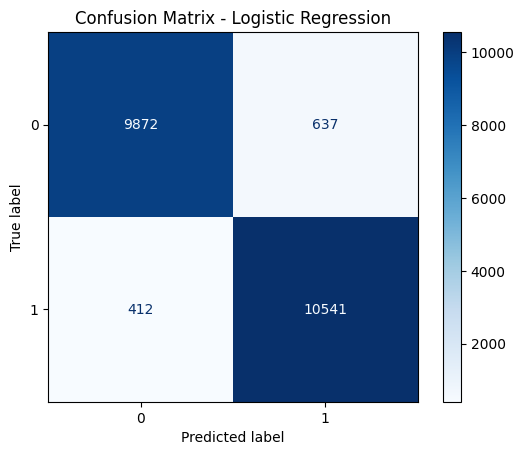

In [ ]:
y_pred_lr = lr.predict(x_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr.classes_)

disp_lr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

BERT

168/168 [==============================] - 20s 118ms/step


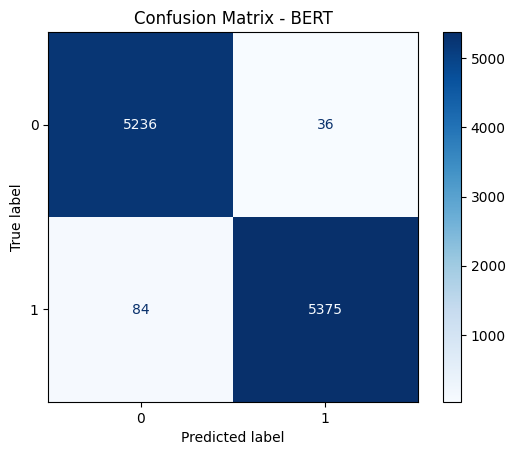

In [ ]:
# Extract true labels and predictions from the TensorFlow dataset
y_true_bert = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)
y_pred_bert = classifier_model.predict(test_ds).flatten()
y_pred_bert_classes = (y_pred_bert >= 0.5).astype(int)

cm_bert = confusion_matrix(y_true_bert, y_pred_bert_classes)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=[0, 1])

disp_bert.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT")
plt.show()

### Training and Validation Loss of BERT

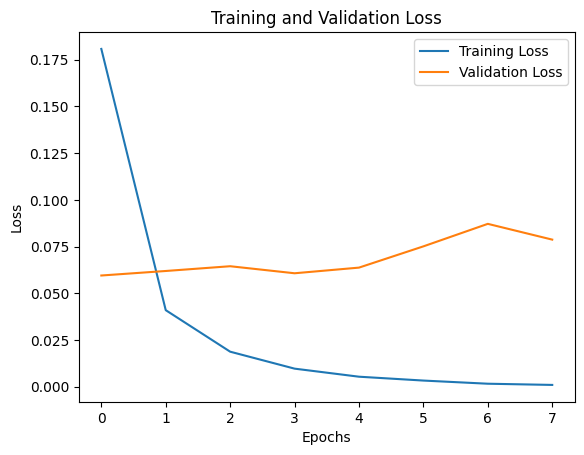

In [ ]:
# From classifier_model's history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# From saved history
# history_npy = np.load(get_drive_path('my_history.npy'), allow_pickle='TRUE').item()
# plt.plot(history_npy['loss'], label='Training Loss')
# plt.plot(history_npy['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Training and Accuracy Loss of BERT

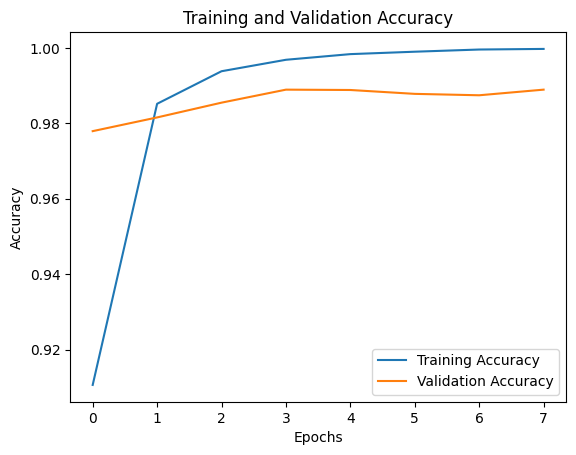

In [ ]:
# From classifier_model's history
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')

# From saved history
# history_npy = np.load(get_drive_path('my_history.npy'), allow_pickle='TRUE').item()
# plt.plot(history_npy['binary_accuracy'], label='Training Accuracy')
# plt.plot(history_npy['val_binary_accuracy'], label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()